In [1]:
%matplotlib inline

from collections import Counter
from collections import defaultdict
import glob
import gzip
from itertools import izip
import os

from IPython.core.display import HTML
import pandas as pd
import numpy as np
import screed
from scipy import stats
from scipy.stats import linregress
import seaborn as sns

from gscripts.general import dataviz
from gscripts.rnaseq import helpers

img_dir = "."


In [2]:
counts = pd.read_table("/nas3/gpratt/Dropbox/TAF15/Data/MN_data/all_counts.txt", skiprows=1, index_col=0)
counts = counts.ix[:,counts.columns.map(lambda x: "merged" not in x)]

exon_counts = pd.read_table("/nas3/gpratt/Dropbox/TAF15/Data/MN_data/MN_CLIP_counts.txt", skiprows=1, index_col=0)


In [3]:
illumina_colors = dict(zip(range(1,25), sns.cubehelix_palette(24, light=.9, dark=.1, reverse=True, start=1, rot=-2)))
inline_colors = dict(zip(["A01", "A04", "B06", "C01", "D08fixed", "G07", "unassigned"], sns.color_palette("Set1", 7)))
expected_colors = dict(zip(["expected", "unexpected"], sns.color_palette("Set1", 2)))
rbp_colors = dict(zip(["taf", 'fus', 'tdp'], sns.color_palette("Set1", 3)))

In [4]:
def update_index(df):
    new_index = []

    for item in df.index:
        illumina_id, inline_barcode = item.split(".")[:2]
        illumina_id = "_".join(illumina_id.split("_")[:-2])
        inline_barcode = inline_barcode.split("_")
        kk_id = illumina_id.split("_")[1]
        barcode_modified = inline_barcode[0]
        if len(inline_barcode) > 1:
            expectation = "expected"
        else:
            expectation = "unexpected"
        new_index.append([illumina_id, barcode_modified, expectation, kk_id])


    df.index = pd.MultiIndex.from_tuples(new_index, names=['name', 'inline_barcode', 'demux_status', 'kk_id'])
    return df

def label_counts(counts):
    rpkm = helpers.counts_to_rpkm(counts)
    rpkm = rpkm.T
    rpkm = update_index(rpkm)
    rpkm = rpkm.T[~(rpkm.sum() == 0).values]
    return rpkm
    

In [5]:
rpkm = label_counts(counts)
exon_rpkm = label_counts(exon_counts)

In [6]:
filtered_rpkm = rpkm.ix[:,(counts.ix[:, 5:].sum() > 1000).values]

In [8]:
def linear_regression(rpkm):
    
    result = defaultdict(dict)
    for item_1 in rpkm.columns:
        for item_2 in rpkm.columns:
            result[item_1][item_2] = linregress(rpkm[item_1], rpkm[item_2])[2]

    result = pd.DataFrame(result)
    return result

result = linear_regression(rpkm)
exon_result = linear_regression(exon_rpkm)
only_large_result = linear_regression(filtered_rpkm)

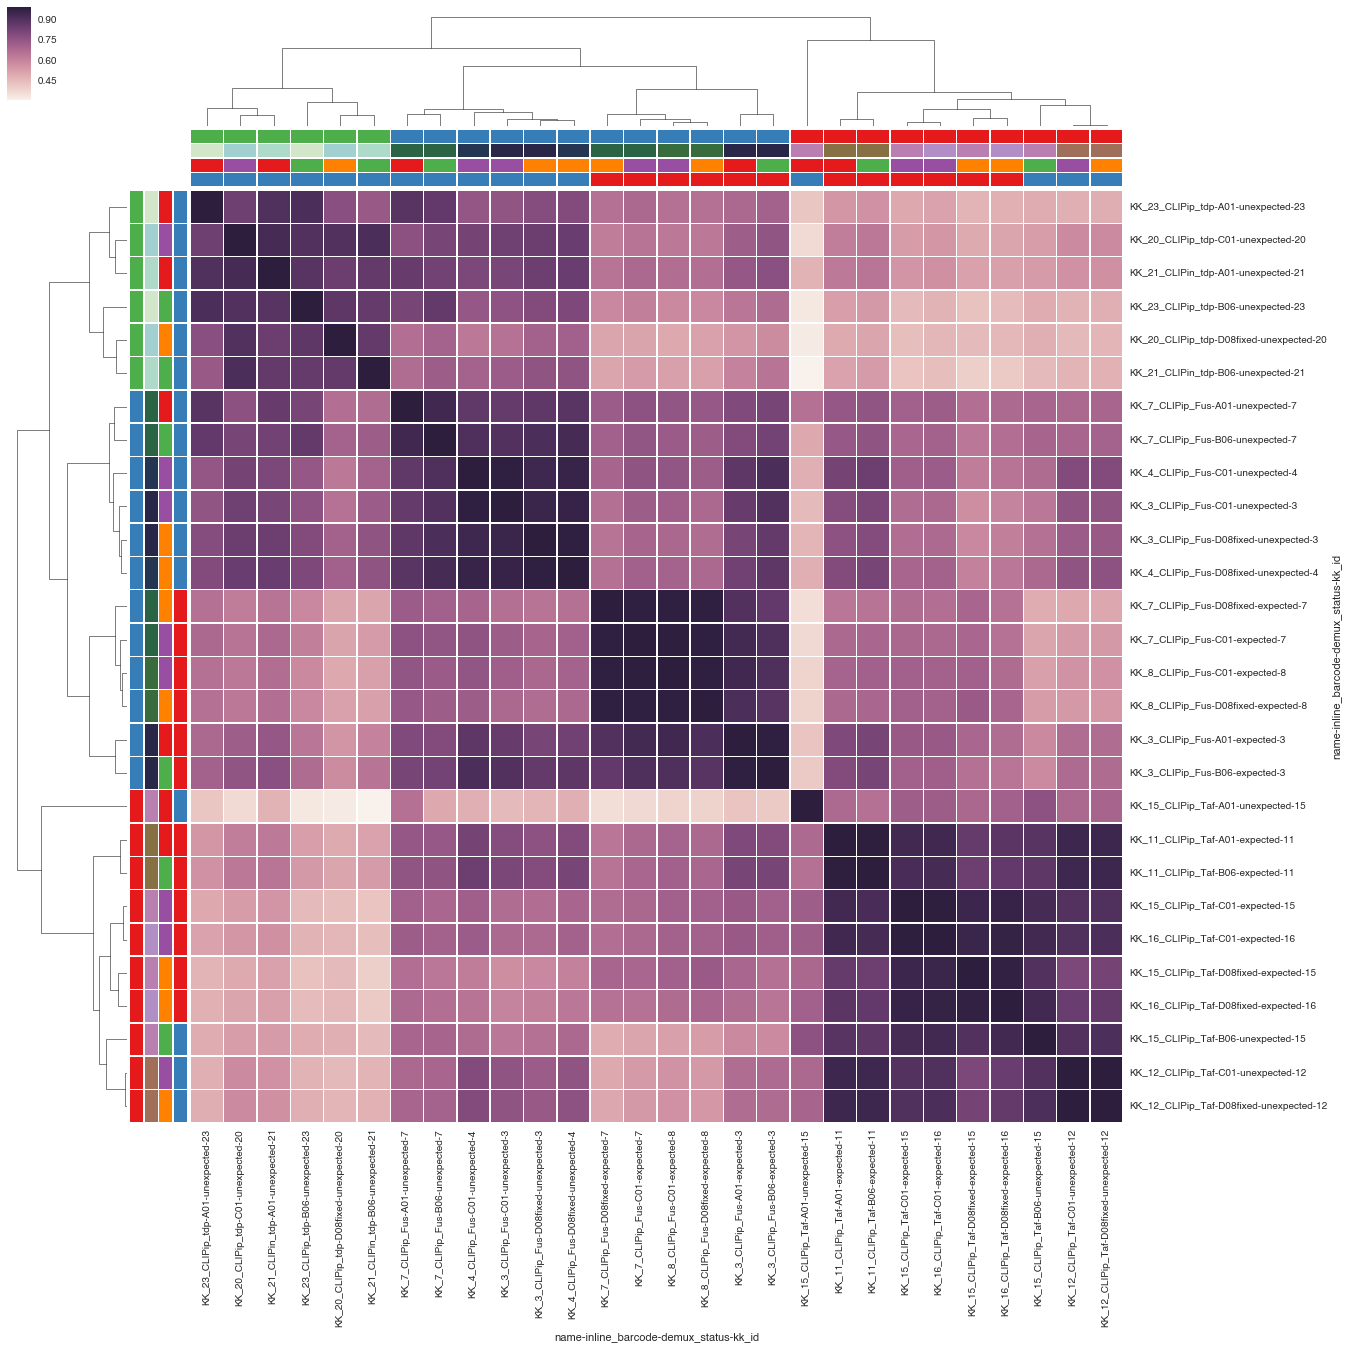

In [23]:
filtered_result = exon_result.ix[exon_result.index.get_level_values(level=1).map(lambda x: x != "unassigned"),
                            exon_result.columns.get_level_values(level=1).map(lambda x: x != "unassigned")]

filtered_result = filtered_result.ix[pos_bw.index,
                                    pos_bw.index].dropna([0,1], how="all")

illumina_color_results = filtered_result.index.get_level_values(level=0).map(lambda x: illumina_colors[int(x.split("_")[1])])
inline_color_results = filtered_result.index.get_level_values(level=1).map(lambda x: inline_colors[x])
expected_color_results = filtered_result.index.get_level_values(level=2).map(lambda x: expected_colors[x])
rbp_color_results = filtered_result.index.get_level_values(level=0).map(lambda x: rbp_colors[x.split("_")[3].lower()[:3]])

sns.clustermap(filtered_result, 
               col_colors=[rbp_color_results, illumina_color_results, inline_color_results, expected_color_results], 
               row_colors=[rbp_color_results, illumina_color_results, inline_color_results, expected_color_results], 
               figsize=(20,20),
               linewidths=.1)

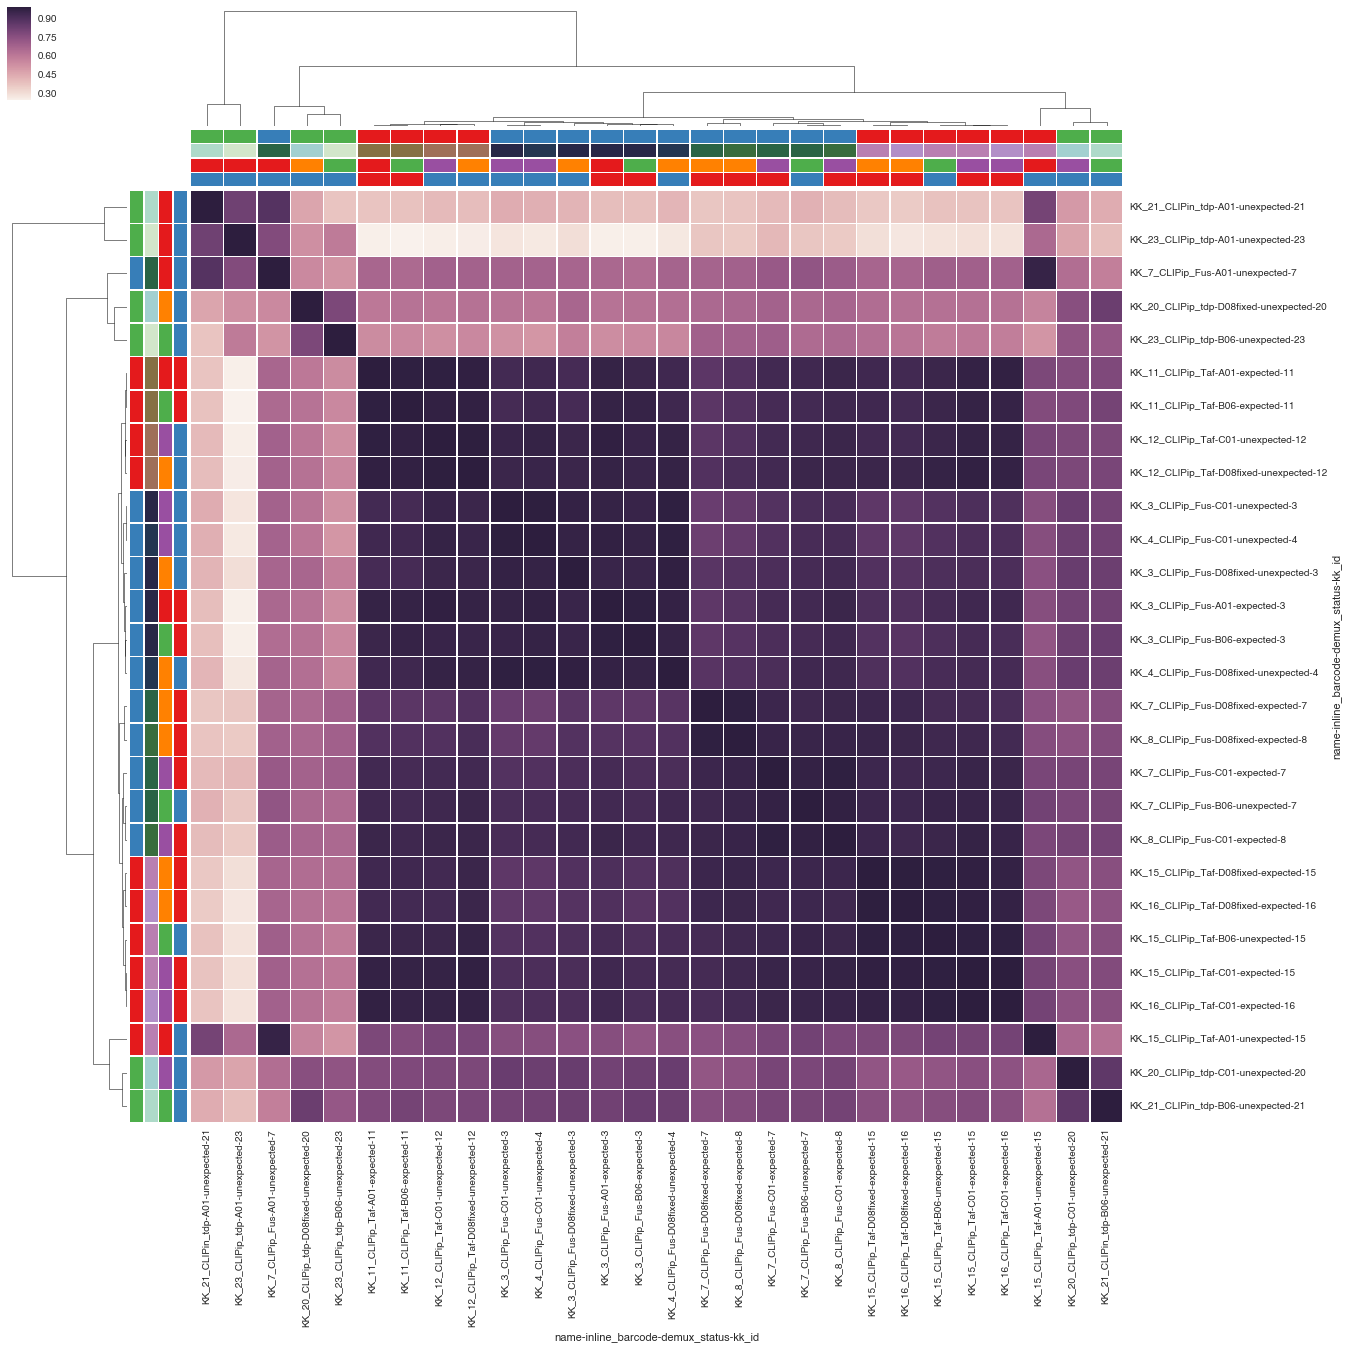

In [24]:
filtered_result = result.ix[result.index.get_level_values(level=1).map(lambda x: x != "unassigned"),
                            result.columns.get_level_values(level=1).map(lambda x: x != "unassigned")]


filtered_result = filtered_result.ix[pos_bw.index,
                                    pos_bw.index].dropna([0,1], how="all")

illumina_color_results = filtered_result.index.get_level_values(level=0).map(lambda x: illumina_colors[int(x.split("_")[1])])
inline_color_results = filtered_result.index.get_level_values(level=1).map(lambda x: inline_colors[x])
expected_color_results = filtered_result.index.get_level_values(level=2).map(lambda x: expected_colors[x])
rbp_color_results = filtered_result.index.get_level_values(level=0).map(lambda x: rbp_colors[x.split("_")[3].lower()[:3]])

sns.clustermap(filtered_result, 
               col_colors=[rbp_color_results, illumina_color_results, inline_color_results, expected_color_results], 
               row_colors=[rbp_color_results, illumina_color_results, inline_color_results, expected_color_results], 
               figsize=(20,20),
               linewidths=.1)

In [78]:
(filtered_result.index.get_level_values(level=0) == "KK_4_CLIPip_Fus") & (filtered_result.index.get_level_values(level=2) == "expected")

array([False, False, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False], dtype=bool)

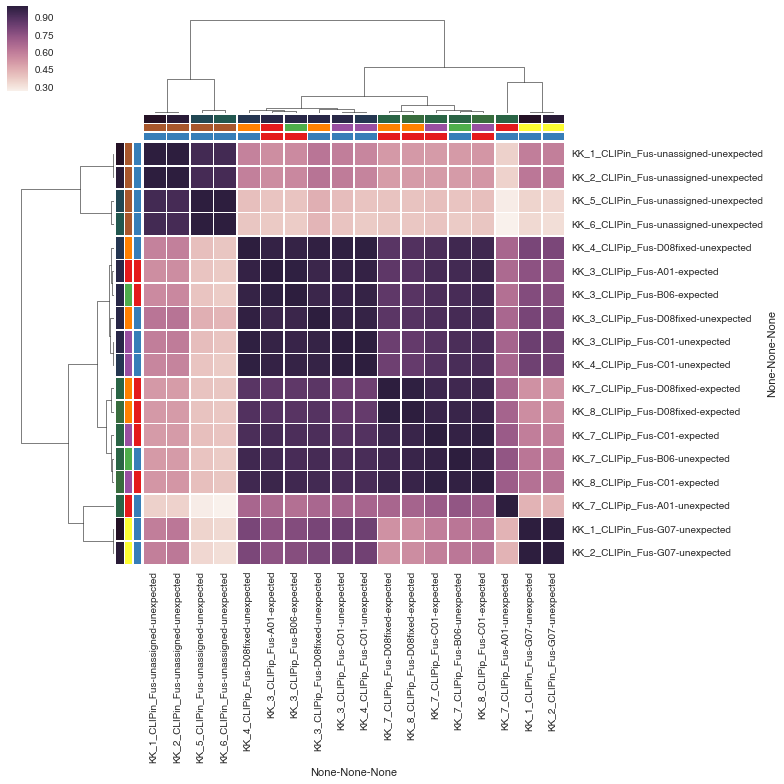

In [108]:
filtered_result = result.ix[result.index.get_level_values(level=0).map(lambda x: x.split("_")[3] == "Fus"),
                            result.columns.get_level_values(level=0).map(lambda x: x.split("_")[3] == "Fus")]

filtered_result = filtered_result.ix[~((filtered_result.index.get_level_values(level=0) == "KK_4_CLIPip_Fus") & (filtered_result.index.get_level_values(level=2) == "expected")),
                                     ~((filtered_result.columns.get_level_values(level=0) == "KK_4_CLIPip_Fus") & (filtered_result.columns.get_level_values(level=2) == "expected"))]

illumina_color_results = filtered_result.index.get_level_values(level=0).map(lambda x: illumina_colors[int(x.split("_")[1])])
inline_color_results = filtered_result.index.get_level_values(level=1).map(lambda x: inline_colors[x])
expected_color_results = filtered_result.index.get_level_values(level=2).map(lambda x: expected_colors[x])
rbp_color_results = filtered_result.index.get_level_values(level=0).map(lambda x: rbp_colors[x.split("_")[3].lower()[:3]])

sns.clustermap(filtered_result, 
               col_colors=[illumina_color_results, inline_color_results, expected_color_results], 
               row_colors=[illumina_color_results, inline_color_results, expected_color_results], 
               figsize=(10,10),
               linewidths=.1)

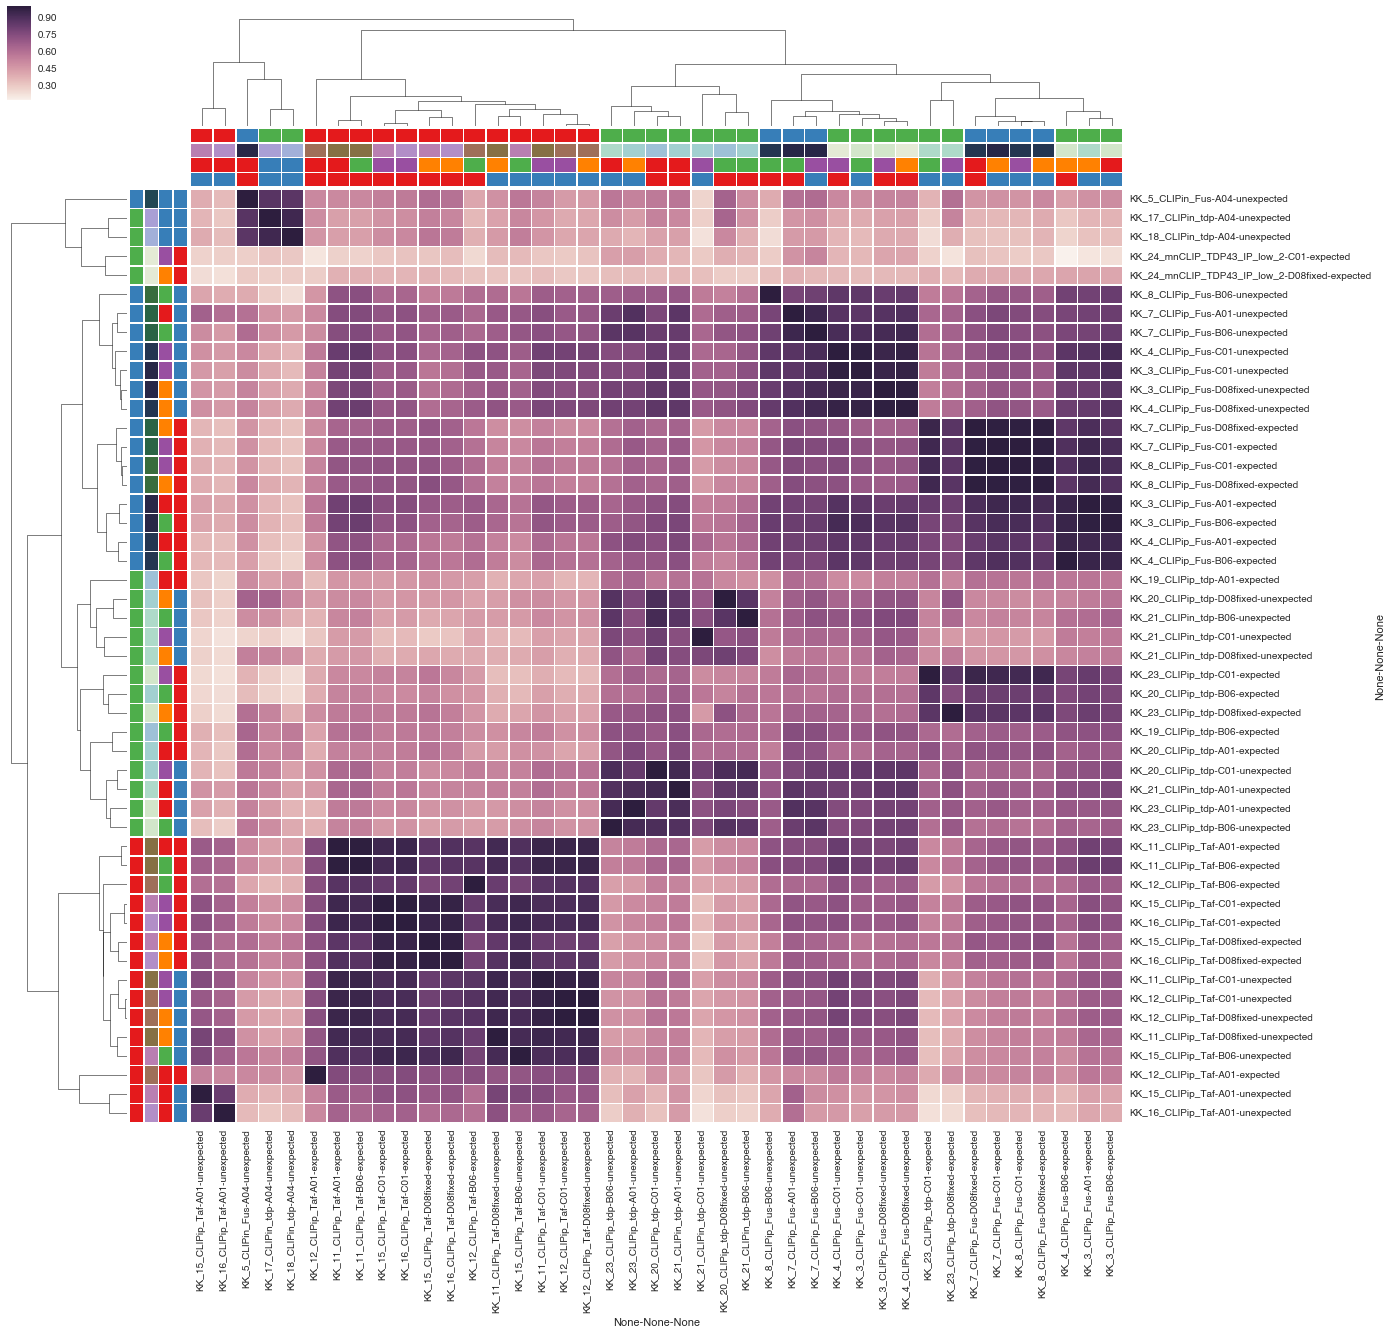

In [58]:
filtered_result = only_large_result.ix[only_large_result.index.get_level_values(level=1).map(lambda x: x != "unassigned"),
                            only_large_result.columns.get_level_values(level=1).map(lambda x: x != "unassigned")]

illumina_color_results = filtered_result.index.get_level_values(level=0).map(lambda x: illumina_colors[int(x.split("_")[1])])
inline_color_results = filtered_result.index.get_level_values(level=1).map(lambda x: inline_colors[x])
expected_color_results = filtered_result.index.get_level_values(level=2).map(lambda x: expected_colors[x])
rbp_color_results = filtered_result.index.get_level_values(level=0).map(lambda x: rbp_colors[x.split("_")[3].lower()[:3]])

sns.clustermap(filtered_result, 
               col_colors=[rbp_color_results, illumina_color_results, inline_color_results, expected_color_results], 
               row_colors=[rbp_color_results, illumina_color_results, inline_color_results, expected_color_results], 
               figsize=(20,20),
               linewidths=.1)

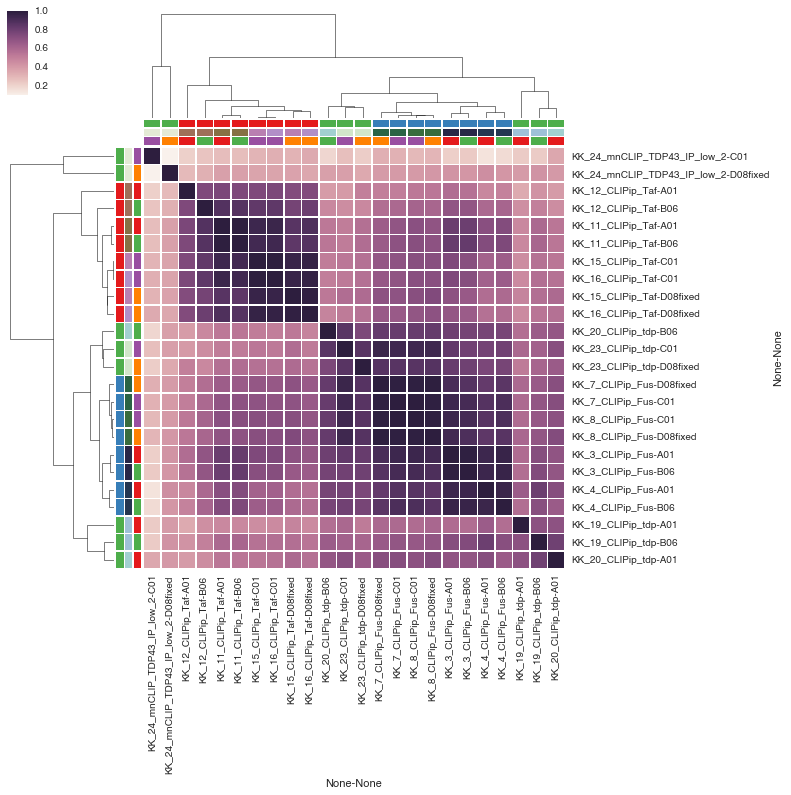

In [60]:
filtered_result = result.xs("expected", level=2).T.xs("expected", level=2)

illumina_color_results = filtered_result.index.get_level_values(level=0).map(lambda x: illumina_colors[int(x.split("_")[1])])
inline_color_results = filtered_result.index.get_level_values(level=1).map(lambda x: inline_colors[x])
#expected_color_results = filtered_result.index.get_level_values(level=2).map(lambda x: expected_colors[x])
rbp_color_results = filtered_result.index.get_level_values(level=0).map(lambda x: rbp_colors[x.split("_")[3].lower()[:3]])

sns.clustermap(filtered_result, 
               col_colors=[rbp_color_results, illumina_color_results, inline_color_results], 
               row_colors=[rbp_color_results, illumina_color_results, inline_color_results], 
               figsize=(10,10),
              linewidth=.1)


Ok so for the most part the expected things cluster together, maybe don't worry about the strange barcodes, 

In [139]:
well_expressed_genes = filtered_rpkm[(filtered_rpkm != 0).sum(axis=1) > len(filtered_rpkm.columns) / 2]
cv = well_expressed_genes.std(axis=1) / well_expressed_genes.mean(axis=1)

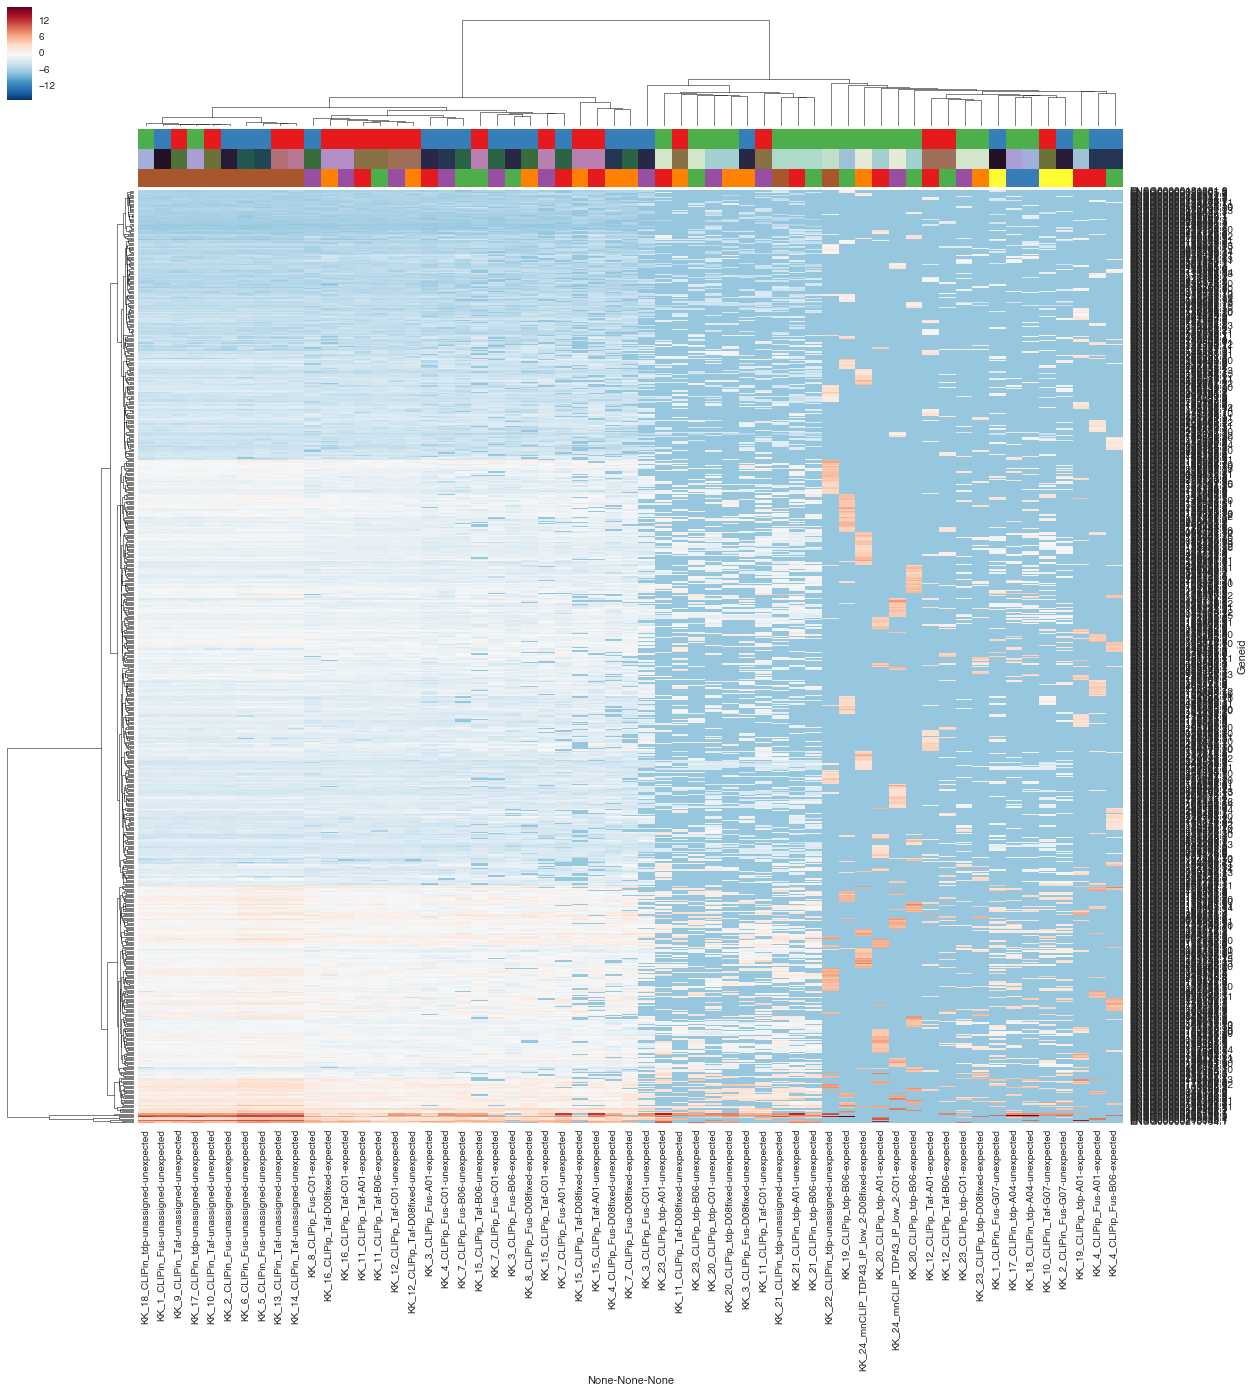

In [164]:
illumina_color_results = well_expressed_genes.columns.get_level_values(level=0).map(lambda x: illumina_colors[int(x.split("_")[1])])
inline_color_results = well_expressed_genes.columns.get_level_values(level=1).map(lambda x: inline_colors[x])
rbp_color_results = well_expressed_genes.columns.get_level_values(level=0).map(lambda x: rbp_colors[x.split("_")[3].lower()[:3]])

sns.clustermap(np.log2(well_expressed_genes[cv > 3] + .01), 
               col_colors=[rbp_color_results, illumina_color_results, inline_color_results], 
               #row_colors=[rbp_color_results, illumina_color_results, inline_color_results], 
               figsize=(20,20),
              linewidth=0)

#Look at wig level correlation

In [25]:
!scp -q tscc-login.sdsc.edu:/home/gpratt/projects/encode/analysis/encode_v8/KK*.bw /nas3/gpratt/projects/encode/analysis/encode_v8/

In [9]:
def correlate_wigs(a, b):
    x = !wigCorrelate $a $b
    sample1, sample2, correlation = x[0].split()
    return sample1, sample2, float(correlation)

In [75]:
pos_bw = glob.glob("/nas3/gpratt/projects/encode/analysis/encode_v8/*pos.bw")
pos_bw = pd.Series({".".join(os.path.basename(fn).split(".")[:2]) : fn for  fn in pos_bw})
pos_bw = update_index(pos_bw)
pos_bw = pos_bw[pos_bw.index.get_level_values(level="inline_barcode").map(lambda x: x != "merged")]
pos_bw = pd.DataFrame(pos_bw)
pos_bw.columns = ['file_name']
pos_bw["kk_id"] = pos_bw.index.get_level_values(level="kk_id")
pos_bw["demux_status"] = pos_bw.index.get_level_values(level="demux_status")

neg_bw = glob.glob("/nas3/gpratt/projects/encode/analysis/encode_v8/*neg.bw")
neg_bw = pd.Series({".".join(os.path.basename(fn).split(".")[:2]) : fn for  fn in neg_bw})
neg_bw = update_index(neg_bw)
neg_bw = neg_bw[neg_bw.index.get_level_values(level="inline_barcode").map(lambda x: x != "merged")]
neg_bw = pd.DataFrame(neg_bw)
neg_bw.columns = ['file_name']
neg_bw["kk_id"] = neg_bw.index.get_level_values(level="kk_id")
neg_bw["demux_status"] = neg_bw.index.get_level_values(level="demux_status")

In [ ]:
def wig_correlation(bw_files):
    
    result = defaultdict(dict)
    for name_1, fn_1 in bw_files.iteritems():
        for name_2, fn_2 in bw_files.iteritems():
            result[name_1][name_2] = correlate_wigs(fn_1, fn_2)[2]

    result = pd.DataFrame(result)
    return result

pos_bw_correlation = wig_correlation(pos_bw)


In [211]:
neg_bw_correlation = wig_correlation(neg_bw)


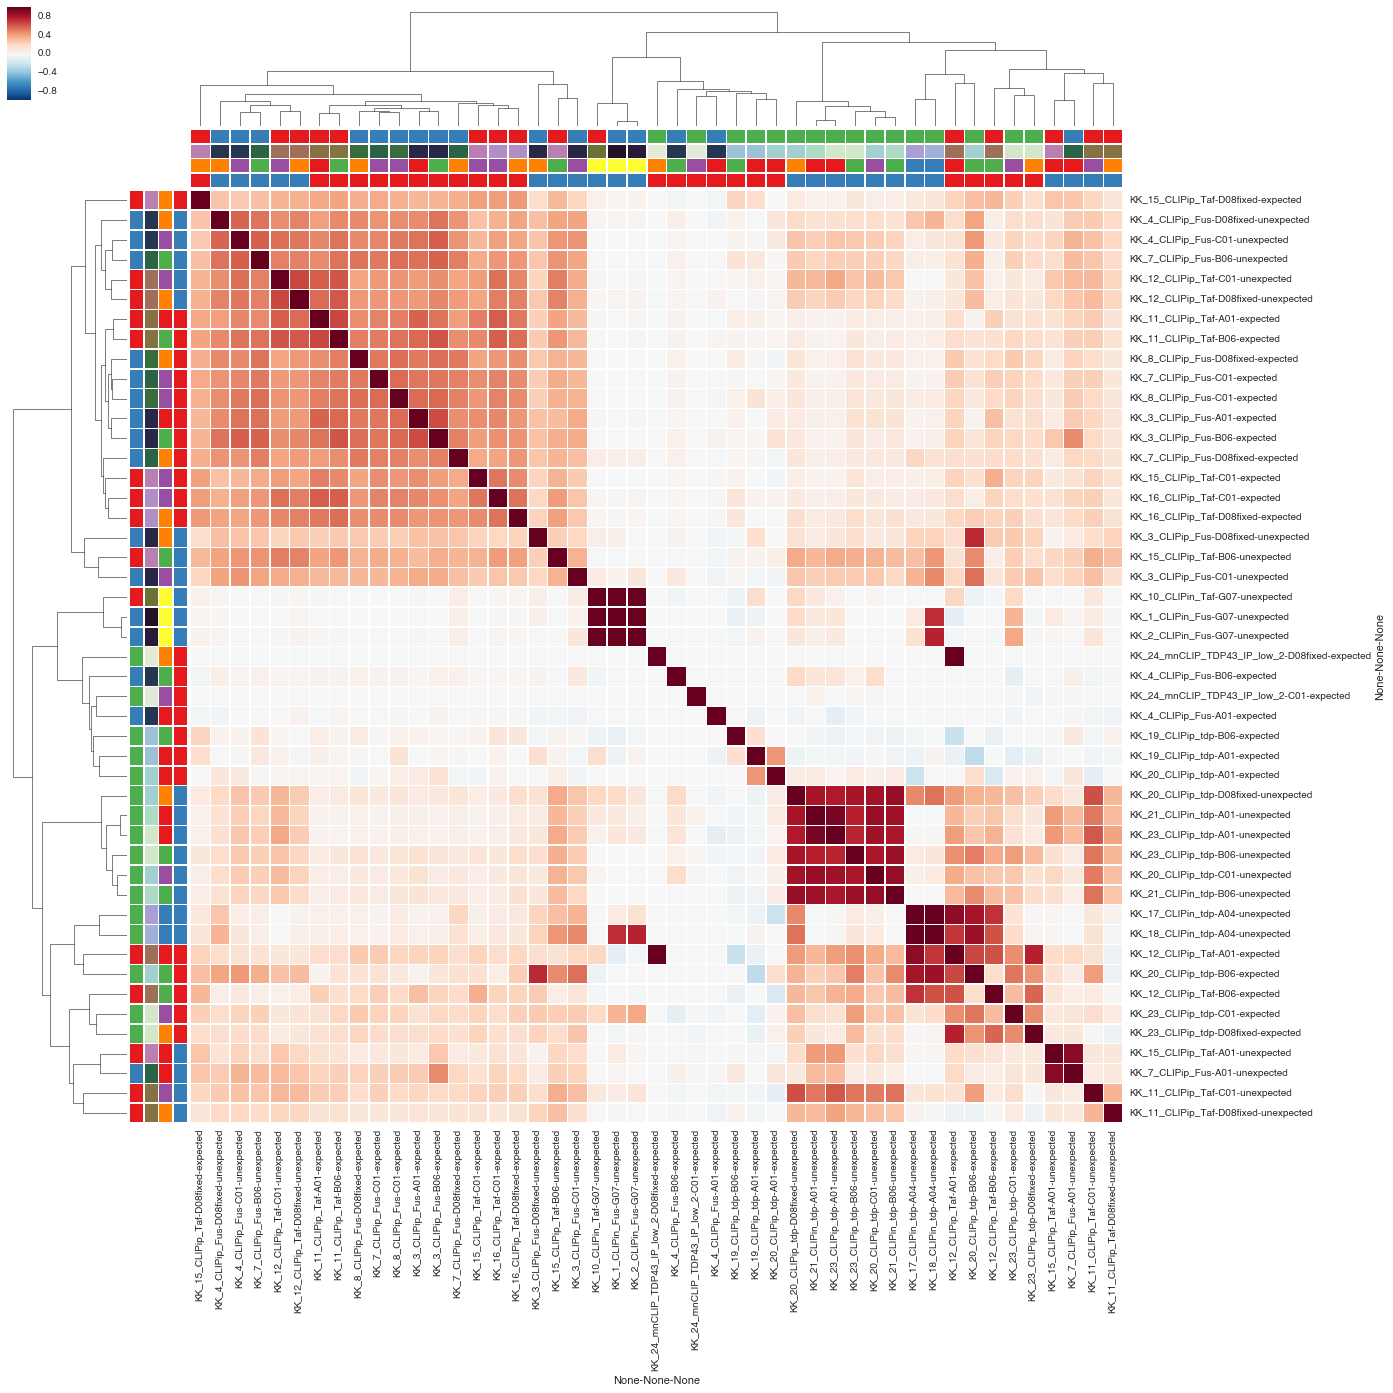

In [13]:
filtered_result = pos_bw_correlation.ix[pos_bw_correlation.index.get_level_values(level=1).map(lambda x: x != "unassigned"),
                            pos_bw_correlation.columns.get_level_values(level=1).map(lambda x: x != "unassigned")]

illumina_color_results = filtered_result.index.get_level_values(level=0).map(lambda x: illumina_colors[int(x.split("_")[1])])
inline_color_results = filtered_result.index.get_level_values(level=1).map(lambda x: inline_colors[x])
expected_color_results = filtered_result.index.get_level_values(level=2).map(lambda x: expected_colors[x])
rbp_color_results = filtered_result.index.get_level_values(level=0).map(lambda x: rbp_colors[x.split("_")[3].lower()[:3]])

sns.clustermap(filtered_result.fillna(0), 
               col_colors=[rbp_color_results, illumina_color_results, inline_color_results, expected_color_results], 
               row_colors=[rbp_color_results, illumina_color_results, inline_color_results, expected_color_results], 
               figsize=(20,20),
               linewidths=.1)

#Samples to toss

2. KK 1 and 2 inputs (that have barcodes, they look different, probably just sequencing depth issues causing contamination
3. KK-4 expecteds, sequencing depth too low
3. KK-10 input is just too deeply sequenced (probably)
5. KK-11 unexpected sequencing depth is low, may just be deeply sequenced and making it through
5. KK-12 expected sequencing depth is low, may throw off clustering (unknown if correct or incorrect)
3. KK-17 input is just too deeply sequenced (probably)
3. KK-18 input is just too deeply sequenced (probably)
4. KK 19 expected, sequencing depth too low
5. KK 20 expecteds sequencing depth too low
5. KK-23 expected sequencing depth is low, may throw off clustering (unknown if correct or incorrect)
5. KK-16 unexpected sequencing depth is low, may just be deeply sequenced and making it through
1. all of KK_24 (not enough sequencing depth)

In [93]:
pos_bw = pos_bw.drop(labels=["1", "2", "24", "10", "17", "18", "15"], level="kk_id")
pos_bw = pos_bw[~((pos_bw.kk_id.isin(["4", "19", "20", "23", "12"])) & (pos_bw.demux_status == "expected"))]
pos_bw = pos_bw[~((pos_bw.kk_id.isin(["11", "16"])) & (pos_bw.demux_status == "unexpected"))]

neg_bw = neg_bw.drop(labels=["1", "2", "24", "10", "17", "18"], level="kk_id")
neg_bw = neg_bw[~((neg_bw.kk_id.isin(["4", "19", "20", "23", "12"])) & (neg_bw.demux_status == "expected"))]
neg_bw = neg_bw[~((neg_bw.kk_id.isin(["11", "16"])) & (neg_bw.demux_status == "unexpected"))]

In [57]:
pos_bw_correlation = wig_correlation(pos_bw.file_name)


In [91]:
neg_bw_correlation = wig_correlation(neg_bw.file_name)


In [77]:
pos_bw_correlation = pos_bw_correlation.ix[pos_bw.index,
                                           pos_bw.index]

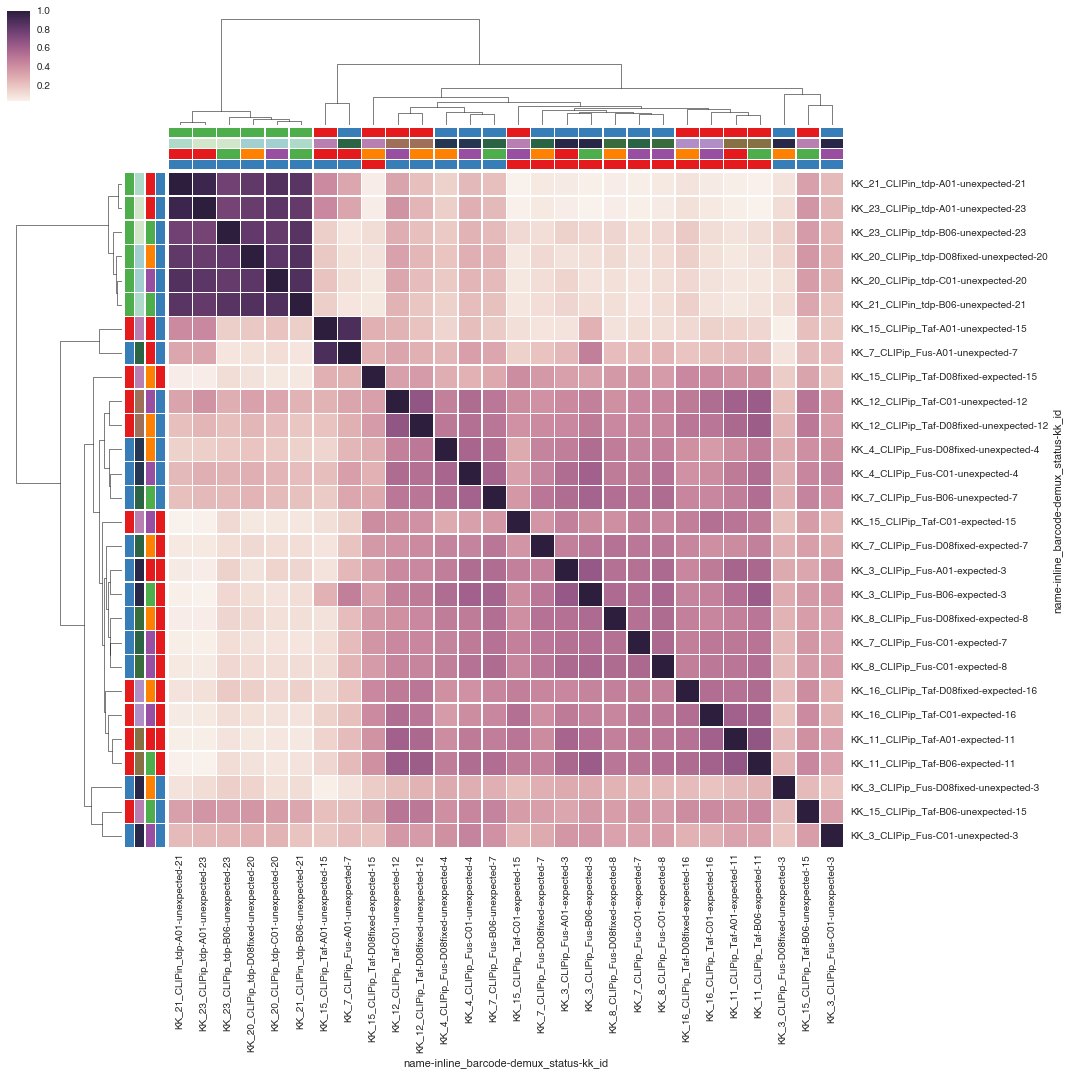

In [83]:
filtered_result = pos_bw_correlation.ix[pos_bw_correlation.index.get_level_values(level=1).map(lambda x: x != "unassigned"),
                            pos_bw_correlation.columns.get_level_values(level=1).map(lambda x: x != "unassigned")]

illumina_color_results = filtered_result.index.get_level_values(level=0).map(lambda x: illumina_colors[int(x.split("_")[1])])
inline_color_results = filtered_result.index.get_level_values(level=1).map(lambda x: inline_colors[x])
expected_color_results = filtered_result.index.get_level_values(level=2).map(lambda x: expected_colors[x])
rbp_color_results = filtered_result.index.get_level_values(level=0).map(lambda x: rbp_colors[x.split("_")[3].lower()[:3]])

sns.clustermap(filtered_result.fillna(0), 
               col_colors=[rbp_color_results, illumina_color_results, inline_color_results, expected_color_results], 
               row_colors=[rbp_color_results, illumina_color_results, inline_color_results, expected_color_results], 
               figsize=(15,15),
               linewidths=.1)

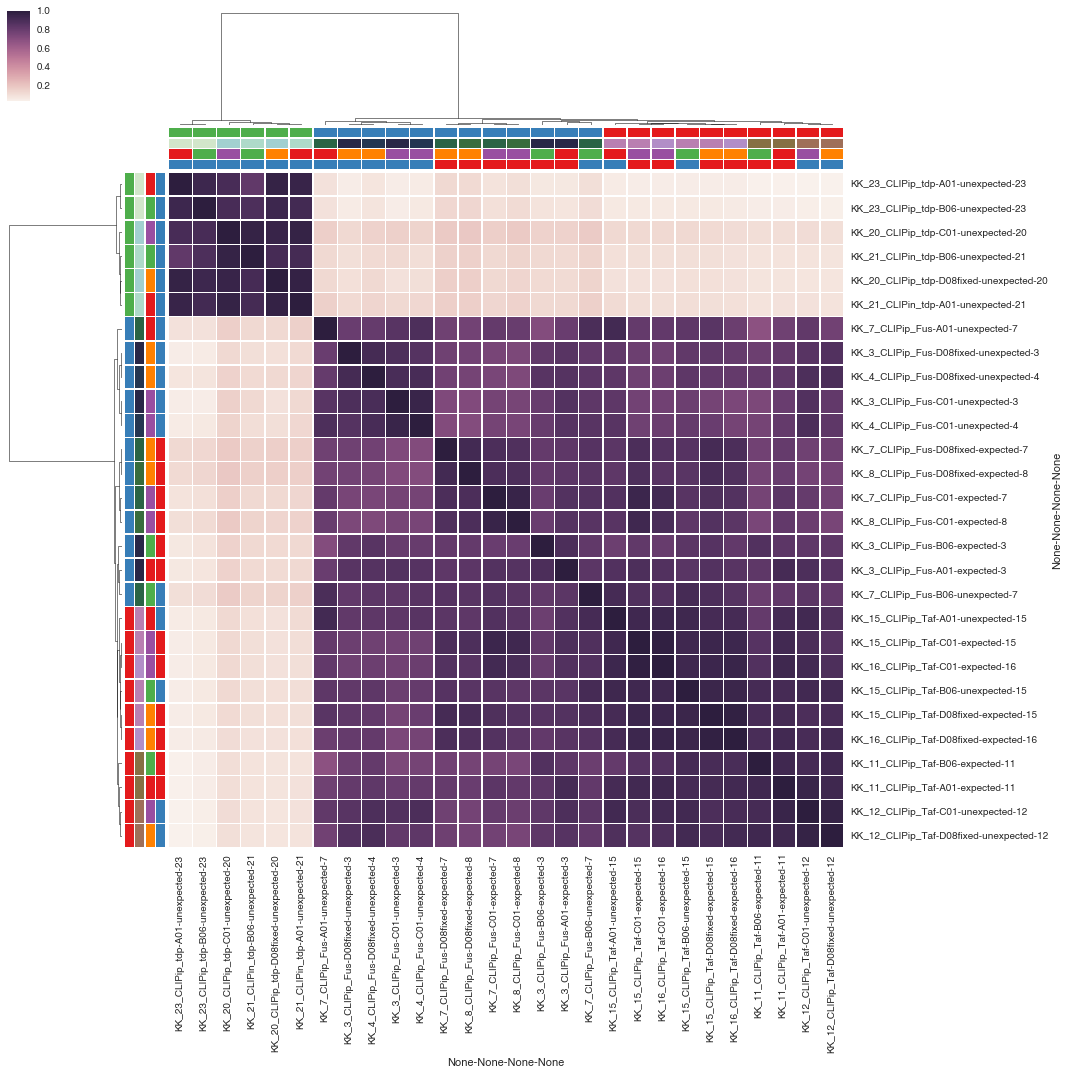

In [92]:
filtered_result = neg_bw_correlation.ix[neg_bw_correlation.index.get_level_values(level=1).map(lambda x: x != "unassigned"),
                            neg_bw_correlation.columns.get_level_values(level=1).map(lambda x: x != "unassigned")]

illumina_color_results = filtered_result.index.get_level_values(level=0).map(lambda x: illumina_colors[int(x.split("_")[1])])
inline_color_results = filtered_result.index.get_level_values(level=1).map(lambda x: inline_colors[x])
expected_color_results = filtered_result.index.get_level_values(level=2).map(lambda x: expected_colors[x])
rbp_color_results = filtered_result.index.get_level_values(level=0).map(lambda x: rbp_colors[x.split("_")[3].lower()[:3]])

sns.clustermap(filtered_result.fillna(0), 
               col_colors=[rbp_color_results, illumina_color_results, inline_color_results, expected_color_results], 
               row_colors=[rbp_color_results, illumina_color_results, inline_color_results, expected_color_results], 
               figsize=(15,15),
               linewidths=.1)

#Conclusions
TDP-43
---
For merging / futher analysis
1. 21 C01
2. 21 A01
3. 23 A01
4. 23 B06
5. 20 Do8
6. 20 C01
7. 21 B06

In [87]:
!scp tscc-login.sdsc.edu:/home/gpratt/projects/encode/analysis/encode_v8/*.coverage.bed .

KK_10_CLIPin_Taf_GAGATTCC-GGCTCTGA_R1.G07.ada 100%   93KB  93.2KB/s   00:00    
KK_10_CLIPin_Taf_GAGATTCC-GGCTCTGA_R1.unassig 100%   98MB  32.7MB/s   00:03    
KK_11_CLIPip_Taf_ATTCAGAA-GGCTCTGA_R1.A01_KK_ 100%   12MB  11.6MB/s   00:00    
KK_11_CLIPip_Taf_ATTCAGAA-GGCTCTGA_R1.B06_KK_ 100%   26MB  12.9MB/s   00:02    
KK_11_CLIPip_Taf_ATTCAGAA-GGCTCTGA_R1.C01.ada 100%   11KB  11.3KB/s   00:00    
KK_11_CLIPip_Taf_ATTCAGAA-GGCTCTGA_R1.D08fixe 100% 7138     7.0KB/s   00:00    
KK_12_CLIPip_Taf_GAATTCGT-GGCTCTGA_R1.A01_KK_ 100%  651     0.6KB/s   00:00    
KK_12_CLIPip_Taf_GAATTCGT-GGCTCTGA_R1.B06_KK_ 100% 1177     1.2KB/s   00:00    
KK_12_CLIPip_Taf_GAATTCGT-GGCTCTGA_R1.C01.ada 100%   22MB   7.5MB/s   00:03    
KK_12_CLIPip_Taf_GAATTCGT-GGCTCTGA_R1.D08fixe 100% 8201KB   8.0MB/s   00:01    
KK_13_CLIPin_Taf_ATTACTCG-AGGCGAAG_R1.unassig 100%   67MB  67.1MB/s   00:01    
KK_14_CLIPin_Taf_TCCGGAGA-AGGCGAAG_R1.unassig 100%   97MB  32.4MB/s   00:03    
KK_15_CLIPip_Taf_CGCTCATT-AGGCGAAG_R1.A0

In [88]:
coverage_beds = glob.glob("*.coverage.bed")
coverage_beds = pd.Series({".".join(os.path.basename(fn).split(".")[:2]) : fn for  fn in coverage_beds})
coverage_beds = update_index(coverage_beds)
coverage_beds = coverage_beds[coverage_beds.index.get_level_values(level="inline_barcode").map(lambda x: x != "merged")]
coverage_beds = pd.DataFrame(coverage_beds)
coverage_beds.columns = ['file_name']
coverage_beds["kk_id"] = coverage_beds.index.get_level_values(level="kk_id")
coverage_beds["demux_status"] = coverage_beds.index.get_level_values(level="demux_status")
beds = coverage_beds.file_name.apply(lambda x: pybedtools.BedTool(x).sort().saveas())

In [89]:
def bed_correlation(bw_files):
    
    result = defaultdict(dict)
    for name_1, bedtool_1 in bw_files.iteritems():
        for name_2, bedtool_2 in bw_files.iteritems():
            names = ["chr_1", "start_1", "stop_1", "name_1", "score_1", "num_overlap_1", "covered_1", "length_1", "fraction_covered_1",
         "chr_2", "start_2", "stop_2", "name_2", "score_2", "num_overlap_2", "covered_2", "length_2", "fraction_covered_2",
         "something_1"]
            
            merged_result = bedtool_1.intersect(bedtool_2, wo=True, f=1.0, sorted=True).to_dataframe(names=names)
            result[name_1][name_2] = stats.pearsonr(merged_result.num_overlap_1, merged_result.num_overlap_2)[0]

    result = pd.DataFrame(result)
    return result

In [95]:
def bed_correlation_overlap_size(bw_files):
    
    result = defaultdict(dict)
    for name_1, bedtool_1 in bw_files.iteritems():
        for name_2, bedtool_2 in bw_files.iteritems():
            names = ["chr_1", "start_1", "stop_1", "name_1", "score_1", "num_overlap_1", "covered_1", "length_1", "fraction_covered_1",
         "chr_2", "start_2", "stop_2", "name_2", "score_2", "num_overlap_2", "covered_2", "length_2", "fraction_covered_2",
         "something_1"]
            
            merged_result = len(bedtool_1.intersect(bedtool_2, wo=True, f=1.0, sorted=True))
            result[name_1][name_2] = merged_result

    result = pd.DataFrame(result)
    return result

In [96]:
corr_size = bed_correlation_overlap_size(beds)


In [90]:
corr = bed_correlation(beds)


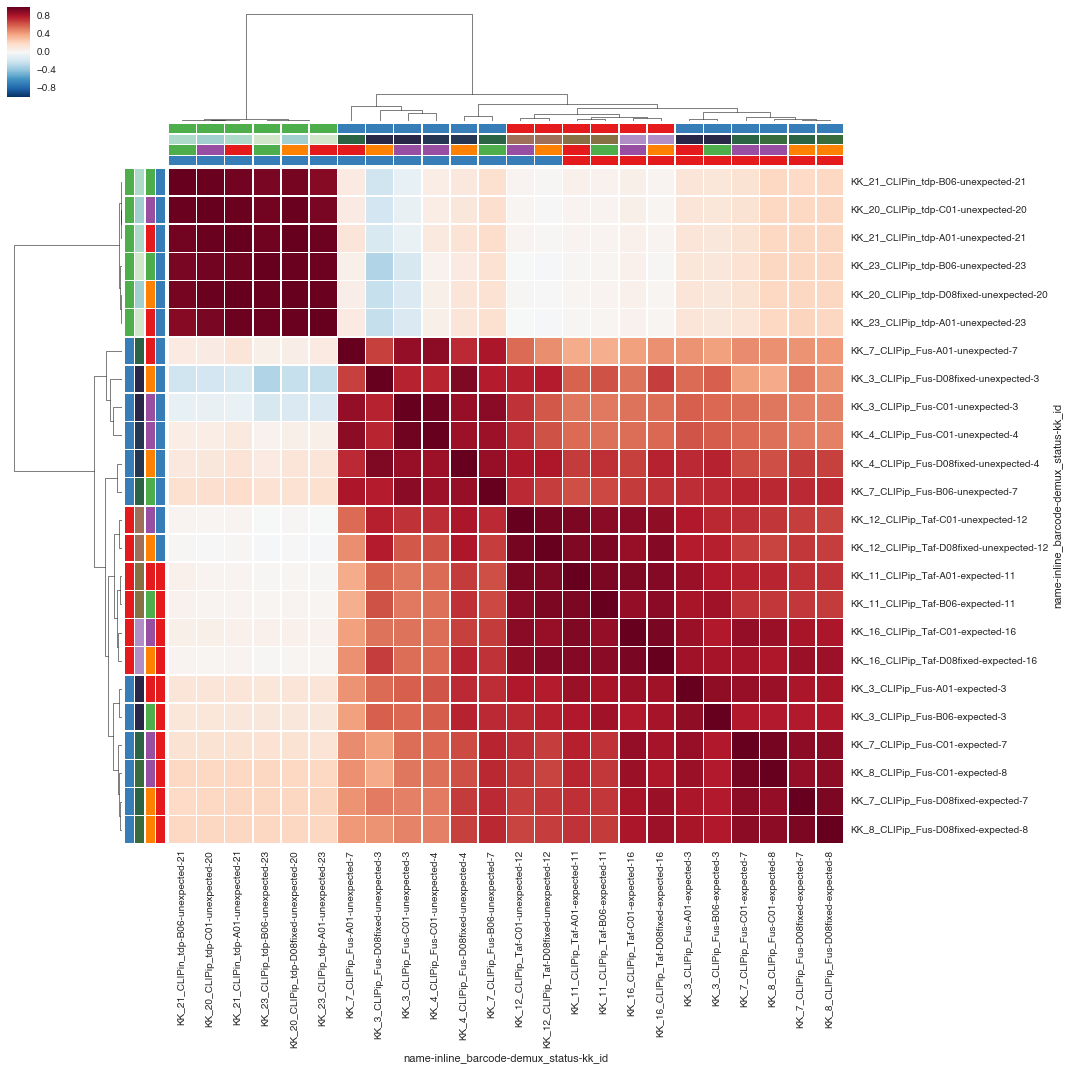

In [107]:
pos_bw = glob.glob("/nas3/gpratt/projects/encode/analysis/encode_v8/*pos.bw")
pos_bw = pd.Series({".".join(os.path.basename(fn).split(".")[:2]) : fn for  fn in pos_bw})
pos_bw = update_index(pos_bw)
pos_bw = pos_bw[pos_bw.index.get_level_values(level="inline_barcode").map(lambda x: x != "merged")]
pos_bw = pd.DataFrame(pos_bw)
pos_bw.columns = ['file_name']
pos_bw["kk_id"] = pos_bw.index.get_level_values(level="kk_id")
pos_bw["demux_status"] = pos_bw.index.get_level_values(level="demux_status")
pos_bw = pos_bw.drop(labels=["1", "2", "24", "10", "17", "18", "15"], level="kk_id")
pos_bw = pos_bw[~((pos_bw.kk_id.isin(["4", "19", "20", "23", "12"])) & (pos_bw.demux_status == "expected"))]
pos_bw = pos_bw[~((pos_bw.kk_id.isin(["11", "16"])) & (pos_bw.demux_status == "unexpected"))]
filtered_result = corr.ix[corr.index.get_level_values(level=1).map(lambda x: x != "unassigned"),
                            corr.columns.get_level_values(level=1).map(lambda x: x != "unassigned")]

filtered_result = filtered_result.ix[pos_bw.index,
                                    pos_bw.index].dropna([0,1], how="all")

illumina_color_results = filtered_result.index.get_level_values(level=0).map(lambda x: illumina_colors[int(x.split("_")[1])])
inline_color_results = filtered_result.index.get_level_values(level=1).map(lambda x: inline_colors[x])
expected_color_results = filtered_result.index.get_level_values(level=2).map(lambda x: expected_colors[x])
rbp_color_results = filtered_result.index.get_level_values(level=0).map(lambda x: rbp_colors[x.split("_")[3].lower()[:3]])

sns.clustermap(filtered_result.fillna(0), 
               col_colors=[rbp_color_results, illumina_color_results, inline_color_results, expected_color_results], 
               row_colors=[rbp_color_results, illumina_color_results, inline_color_results, expected_color_results], 
               figsize=(15,15),
               linewidths=.1)

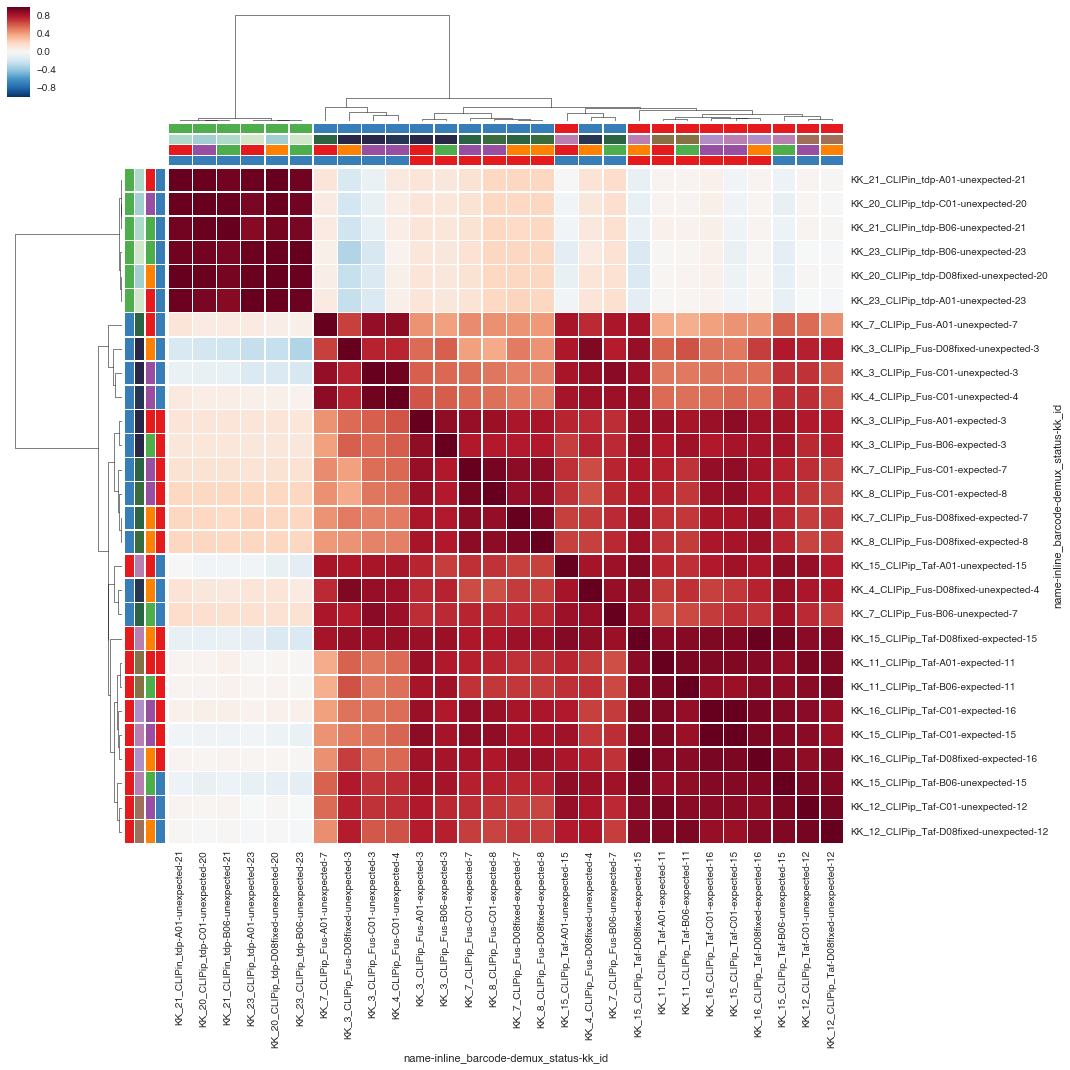

In [108]:
pos_bw = glob.glob("/nas3/gpratt/projects/encode/analysis/encode_v8/*pos.bw")
pos_bw = pd.Series({".".join(os.path.basename(fn).split(".")[:2]) : fn for  fn in pos_bw})
pos_bw = update_index(pos_bw)
pos_bw = pos_bw[pos_bw.index.get_level_values(level="inline_barcode").map(lambda x: x != "merged")]
pos_bw = pd.DataFrame(pos_bw)
pos_bw.columns = ['file_name']
pos_bw["kk_id"] = pos_bw.index.get_level_values(level="kk_id")
pos_bw["demux_status"] = pos_bw.index.get_level_values(level="demux_status")
pos_bw = pos_bw.drop(labels=["1", "2", "24", "10", "17", "18"], level="kk_id")
pos_bw = pos_bw[~((pos_bw.kk_id.isin(["4", "19", "20", "23", "12"])) & (pos_bw.demux_status == "expected"))]
pos_bw = pos_bw[~((pos_bw.kk_id.isin(["11", "16"])) & (pos_bw.demux_status == "unexpected"))]

filtered_result = corr.ix[corr.index.get_level_values(level=1).map(lambda x: x != "unassigned"),
                            corr.columns.get_level_values(level=1).map(lambda x: x != "unassigned")]

filtered_result = filtered_result.ix[pos_bw.index,
                                    pos_bw.index].dropna([0,1], how="all")

illumina_color_results = filtered_result.index.get_level_values(level=0).map(lambda x: illumina_colors[int(x.split("_")[1])])
inline_color_results = filtered_result.index.get_level_values(level=1).map(lambda x: inline_colors[x])
expected_color_results = filtered_result.index.get_level_values(level=2).map(lambda x: expected_colors[x])
rbp_color_results = filtered_result.index.get_level_values(level=0).map(lambda x: rbp_colors[x.split("_")[3].lower()[:3]])

sns.clustermap(filtered_result.fillna(0), 
               col_colors=[rbp_color_results, illumina_color_results, inline_color_results, expected_color_results], 
               row_colors=[rbp_color_results, illumina_color_results, inline_color_results, expected_color_results], 
               figsize=(15,15),
               linewidths=.1)

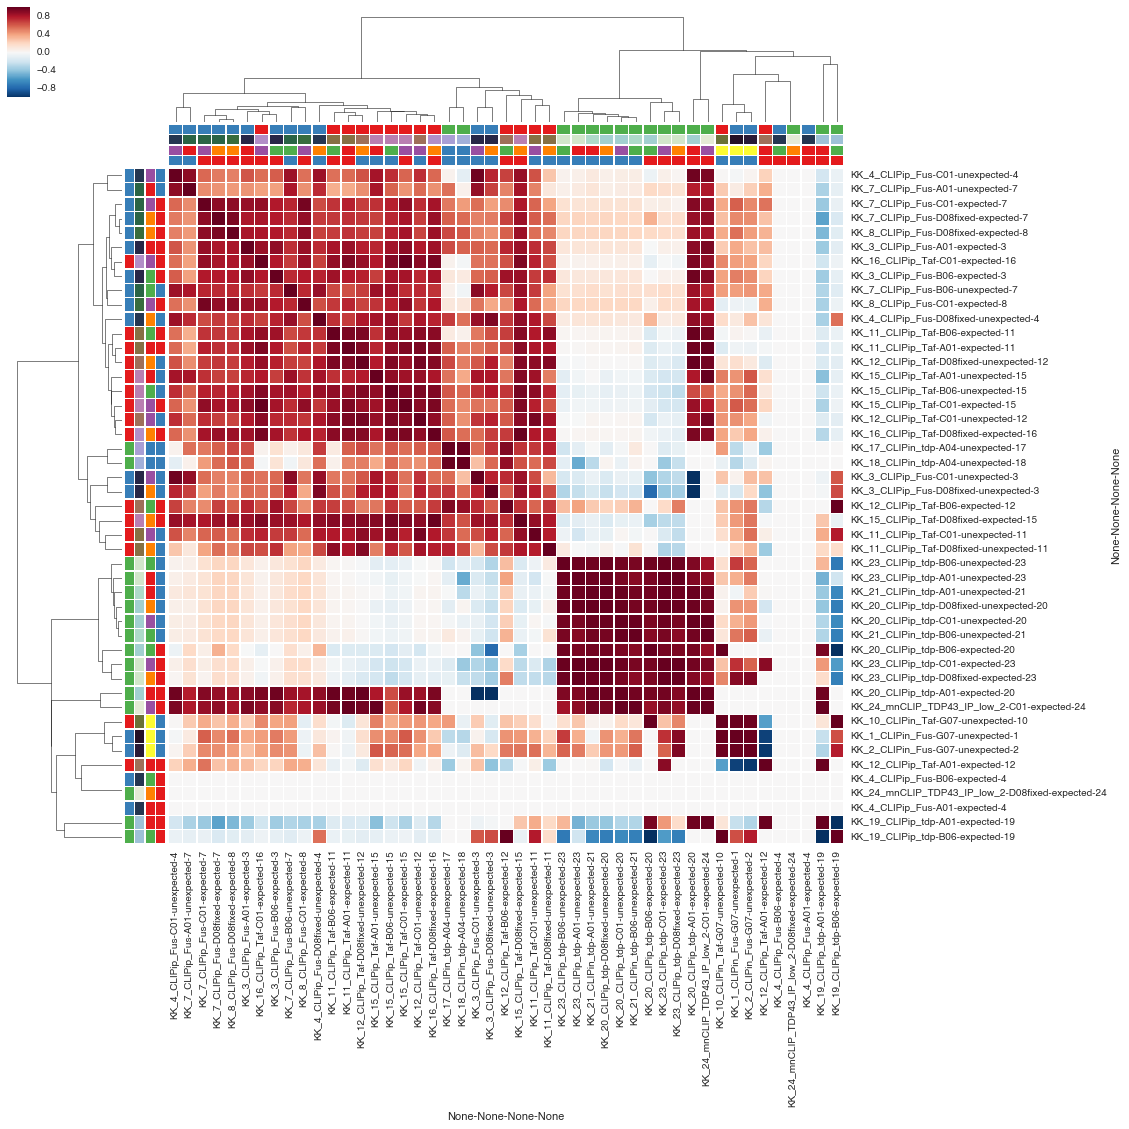

In [92]:
filtered_result = corr.ix[corr.index.get_level_values(level=1).map(lambda x: x != "unassigned"),
                            corr.columns.get_level_values(level=1).map(lambda x: x != "unassigned")]


illumina_color_results = filtered_result.index.get_level_values(level=0).map(lambda x: illumina_colors[int(x.split("_")[1])])
inline_color_results = filtered_result.index.get_level_values(level=1).map(lambda x: inline_colors[x])
expected_color_results = filtered_result.index.get_level_values(level=2).map(lambda x: expected_colors[x])
rbp_color_results = filtered_result.index.get_level_values(level=0).map(lambda x: rbp_colors[x.split("_")[3].lower()[:3]])

sns.clustermap(filtered_result.fillna(0), 
               col_colors=[rbp_color_results, illumina_color_results, inline_color_results, expected_color_results], 
               row_colors=[rbp_color_results, illumina_color_results, inline_color_results, expected_color_results], 
               figsize=(15,15),
               linewidths=.1)